In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import utils # all datareading and preprocessing functionality

In [2]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract'
label_selection = 'label' # can be 'label' or 'text_label'

In [3]:
df = utils.read_abstract_data(negatives_path=file2, positives_path=file1)
#utils.preprocess_text(data) # can be skipped here?

df.head()

,pmid,title,abstract,label,text_label
0,29981025,Impact of Neoadjuvant Chemotherapy on Breast C...,"BACKGROUND: Breast cancer subtype, as determin...",0,control
1,29984001,Expert-Performed Endotracheal Intubation-Relat...,The aim of this study was to determine complic...,0,control
2,29988545,A case report: Addison disease caused by adren...,We report middle age man with skin hyperpigmen...,0,control
3,29998100,An Unusual Morphological Presentation of Cutan...,Cutaneous squamous cell carcinoma (SCC) exhibi...,0,control
4,29999256,Informing Consent: Medical Malpractice and the...,"Since the early 1990s, jurisdictions around th...",0,control


In [4]:
# number of classes
K = df[label_selection].max() + 1
K

2

In [5]:
df_train, df_test = train_test_split(df[[data_selection, 'label', 'text_label']], test_size=0.3)
df_train.head()

,abstract,label,text_label
4562,Fever is one of the most common chief complain...,0,control
2799,Cardiovascular autonomic neuropathy (CAN) is o...,0,control
3207,Dermoid cysts or mature cystic teratoma are th...,0,control
9472,Pesticide use cannot be completely abandoned i...,1,pesticide
6009,Mutations in the secondary quinone electron ac...,1,pesticide


In [ ]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE) # tokenizer from tensorflow.keras.preprocessing.text
tokenizer.fit_on_texts(df_train[data_selection])
sequences_train = tokenizer.texts_to_sequences(df_train[data_selection]) # returns a simple python list of lists (of numbers)
sequences_test = tokenizer.texts_to_sequences(df_test[data_selection])

In [7]:
#df_train.shape
#[len(x) for x in sequences_train[:5]] 
len(sequences_train)

6377

In [8]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 51556 unique tokens.


In [9]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (6377, 1749)


In [10]:
#data_train.shape
data_train[:5, :20]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)

In [ ]:
# also pad the test sequences. Note that we use the same T as for the training data
# (this is important!)
data_test = pad_sequences(sequences_test, maxlen=T)

print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (2733, 1749)


In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 50

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)                    # feel free to test different architectures!
# x = Conv1D(64, 3, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)

In [13]:
from keras import optimizers
optm = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) # these are the default values

# Compile and fit
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer=optm,
  metrics=['accuracy']
)

In [14]:
print('Training model...')
r = model.fit(
  data_train,
  df_train['label'],
  epochs=50,
  validation_data=(data_test, df_test['label'])
)

Training model...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7071 - loss: 0.5694 - val_accuracy: 0.9634 - val_loss: 0.1218
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9730 - loss: 0.0921 - val_accuracy: 0.9671 - val_loss: 0.0849
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9868 - loss: 0.0514 - val_accuracy: 0.9722 - val_loss: 0.0760
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9909 - loss: 0.0349 - val_accuracy: 0.9751 - val_loss: 0.0741
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9953 - loss: 0.0179 - val_accuracy: 0.9766 - val_loss: 0.0748
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9981 - loss: 0.0108 - val_accuracy: 0.9762 - val_loss: 0.0779
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9995 - loss: 0.0062 - val_accuracy: 0.9748 - val_loss: 0.0823
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9999 - loss:

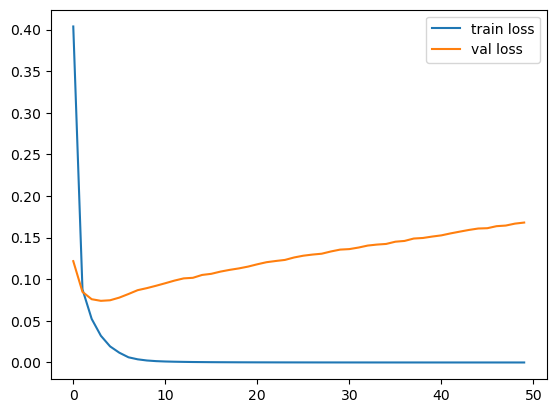

In [15]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

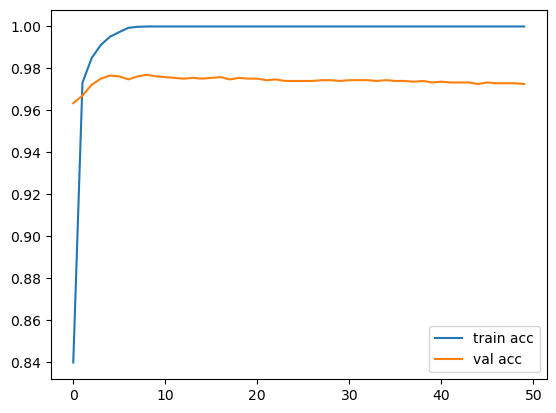

In [16]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [17]:
# The outputs are not probabilities but logits;
# therefore, this check for bigger than zero (=positive class)
# mutltiply by one to get numbers instead of booleans
#P_train = ((model.predict(data_train) > 0) * 1.0).flatten()
P_train = (model.predict(data_train) > 0) * 1.0
P_train = P_train[:, 1] # only positive class

#P_test = ((model.predict(data_test > 0) * 1.0).flatten())
P_test = (model.predict(data_test) > 0) * 1.0
P_test = P_test[:, 1] # only positive


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [19]:
cm_train = confusion_matrix(df_train['label'], P_train, normalize='true')
cm_train

array([[1., 0.],
       [0., 1.]])

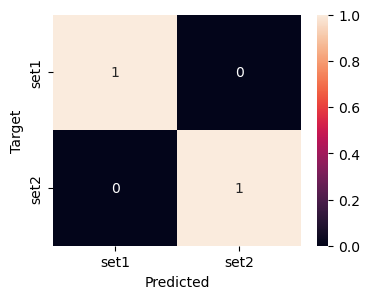

In [20]:
utils.plot_confusion_matrix(cm_train, ['set1', 'set2'])

In [21]:
P_test

array([0., 1., 0., ..., 0., 1., 0.])

In [22]:
cm_test = confusion_matrix(df_test['label'], P_test, normalize='true')
cm_test

array([[0.9807396 , 0.0192604 ],
       [0.03414634, 0.96585366]])

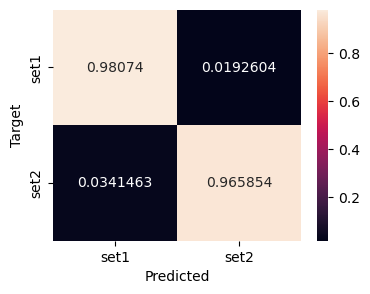

In [23]:
utils.plot_confusion_matrix(cm_test, ['set1', 'set2'])